In [7]:
import pandas as pd

gran = pd.read_excel('qwe/Gran.xlsx', sheet_name='Borough')
gran = gran.drop(columns=['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'])

measure_list = list(gran['Measure'].unique())

for measure in measure_list:
    temp = gran[gran['Measure'] == measure]
    gran[measure] = temp['Proportion']

gran = gran.drop('Measure', axis=1)
gran = gran.drop('Proportion', axis=1)
gran = gran.drop('MPS', axis=1)

gran['Borough'] = gran['Borough'].replace(['Richmond Upon Thames'], ['Richmond upon Thames'])

gran = gran.groupby(['Date', 'Borough']).max().reset_index()
gran = gran.drop('Trust MPS', axis=1)

gran['Average Score'] = gran.loc[:, '"Good Job" local':'Understand issues'].mean(axis=1)
gran['Average Score'] = gran['Average Score'].round(4)
gran['Rank'] = gran.groupby('Date')['Average Score'].rank("dense", ascending=False)

gran.head(50)

gran.to_csv('data/output_files/test.csv', index=False)

In [8]:
import plotly.graph_objects as go

df_alluvial = gran.pivot_table(index='Borough', columns='Date', values='Rank').reset_index()
df_alluvial_melted = df_alluvial.melt(id_vars=['Borough'], var_name='Date', value_name='Rank')

fig = go.Figure()

for borough in df_alluvial['Borough']:
    borough_data = df_alluvial_melted[df_alluvial_melted['Borough'] == borough]
    fig.add_trace(go.Scatter(
        x=borough_data['Date'],
        y=borough_data['Rank'],
        mode='lines+markers',
        name=borough
    ))

fig.update_layout(
    title='Borough Rank Over Time',
    xaxis_title='Date',
    yaxis_title='Rank',
    yaxis=dict(autorange='reversed'),
    showlegend=True,
    xaxis=dict(type='category'),
    width=1100,  # Increase width
    height=1100  # Increase height
)

fig.show()

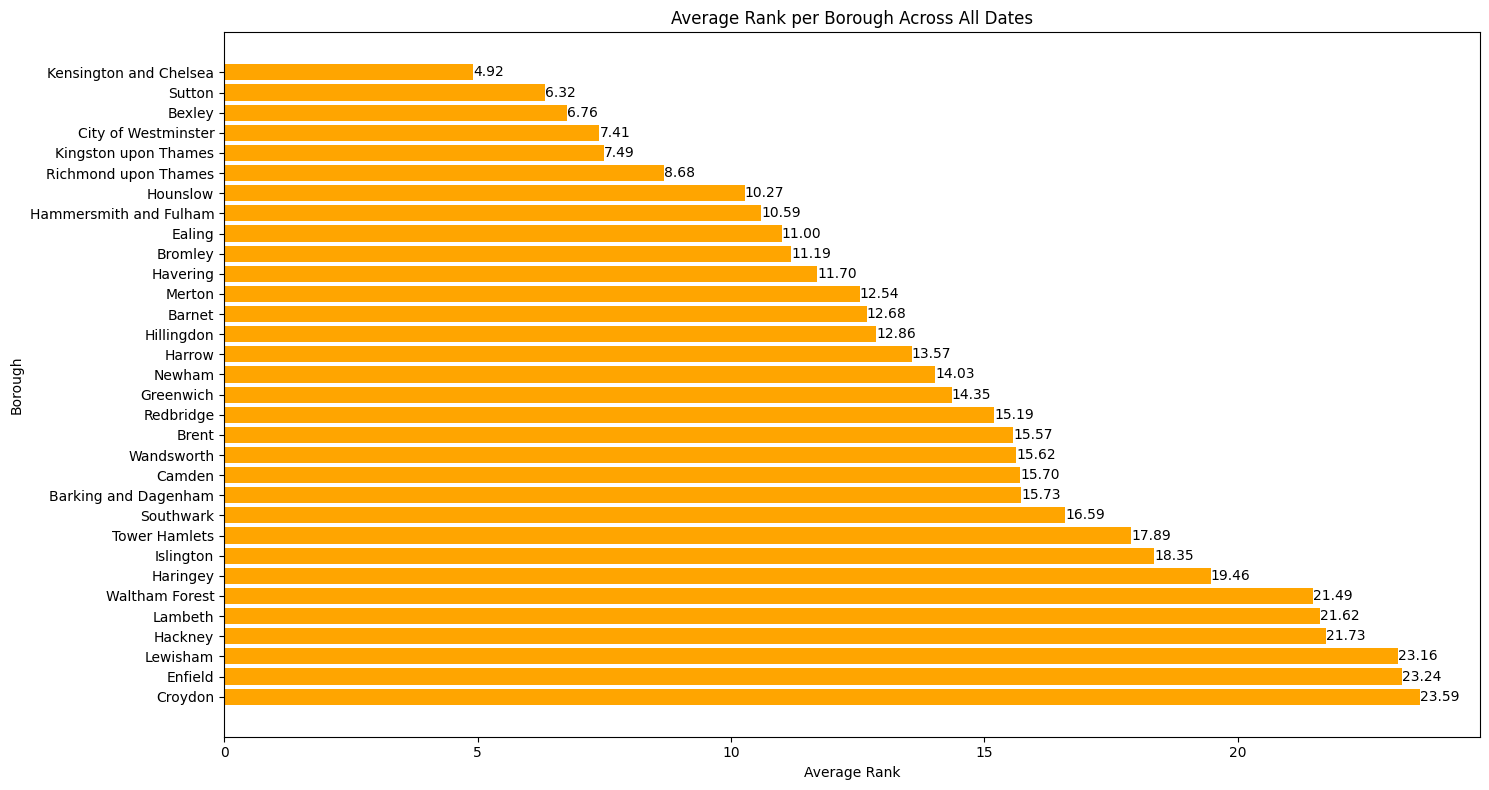

In [9]:
average_ranks = gran.groupby('Borough')['Rank'].mean().reset_index()
average_ranks = average_ranks.sort_values(by='Rank', ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
bars = plt.barh(average_ranks['Borough'], average_ranks['Rank'], color='orange')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}',
             va='center', ha='left')

plt.title('Average Rank per Borough Across All Dates')
plt.xlabel('Average Rank')
plt.ylabel('Borough')
plt.tight_layout()

plt.show()

In [14]:
use1 = pd.read_excel('data/secondary_data/use_of_force/MPS Use of Force - FY24-25.xlsx')

In [15]:
use2 = pd.read_excel('data/secondary_data/use_of_force/MPS Use of Force - FY23-24.xlsx')

In [16]:
use3 = pd.read_excel('data/secondary_data/use_of_force/MPS Use of Force - FY22-23.xlsx')

In [17]:
use4 = pd.read_excel('data/secondary_data/use_of_force/MPS Use of Force - FY21-22.xlsx')

In [18]:
use5 = pd.read_excel('data/secondary_data/use_of_force/MPS Use of Force - FY20-21.xlsx')

In [19]:
use6 = pd.read_excel('data/secondary_data/use_of_force/MPS Use of Force - FY19-20.xlsx')

In [20]:
use7 = pd.read_excel('data/secondary_data/use_of_force/MPS Use of Force - FY18-19.xlsx')

In [21]:
use8 = pd.read_excel('data/secondary_data/use_of_force/MPS Use of Force - FY17-18.xlsx')

In [24]:
uof = pd.concat([use1, use2, use4], axis=0, ignore_index=True)
uof.drop_duplicates(inplace=True) # not number of incidents, each officer may enter the same data 

uof.to_csv('data/output_files/uof2.csv', index=False)


use1.to_csv('data/output_files/use1.csv', index=False)

In [ ]:
date_list = list(gran['Date'].unique())
uof['IncidentDate'] = pd.to_datetime(uof['IncidentDate'])

def find_closest_future_date(initial_date, date_list):
    future_dates = [date for date in date_list if date > initial_date]
    if future_dates:
        return min(future_dates)
    else:
        return None

uof['Date'] = uof['IncidentDate'].apply(lambda x: find_closest_future_date(x, date_list))
uof = uof.dropna(subset=['Date'])
uof['Date'] = pd.to_datetime(uof['Date'])

uof.head(60)

In [ ]:
remove = uof.copy()
remove = remove[['Date', 'Borough']]
# Count occurrences
remove['Occurrences'] = remove.groupby(['Date', 'Borough'])['Borough'].transform('count')

# Remove duplicates
remove = remove.drop_duplicates(subset=['Date', 'Borough'])

remove.head(60)

In [ ]:
temp1 = remove[['Date', 'Borough', 'Occurrences']]
temp2 = gran[['Date', 'Borough', 'Average Score']]
merged_df = pd.merge(temp1, temp2, on=['Date', 'Borough'])
merged_df = merged_df.dropna(subset=['Average Score'])  # dropping boroughs that we don't have data like Heathrow
merged_df = merged_df.reset_index(drop=True)
merged_df.head(60)

In [ ]:
crime1 = pd.read_csv('boroughcrime.csv')
crime2 = pd.read_csv('boroughcrime2.csv')
crime = pd.merge(crime1, crime2, on=['MajorText', 'MinorText', 'BoroughName'], how='left')

columns = crime.columns
filtered_columns = [col for col in columns if (col >= '201410' and col < '202401') or col in ['BoroughName', 'MajorText', 'MinorText']]
crime = crime[filtered_columns]

crime = crime.sort_index(axis=1)
crime.head()

In [ ]:
time_series_cols = [col for col in crime.columns if col.isdigit()]

quarter = crime[['BoroughName', 'MajorText', 'MinorText']].copy()

for i in range(0, len(time_series_cols), 3):
    quarter_cols = time_series_cols[i:i+3]
    if len(quarter_cols) == 3: 
        quarter_name = f"{quarter_cols[0][:4]}Q{(int(quarter_cols[0][4:6]) - 1) // 3 + 1}"
        quarter[quarter_name] = crime[quarter_cols].sum(axis=1)


quarter.head()

In [ ]:
quarter.drop(['MajorText', 'MinorText'], axis=1, inplace=True)
result = quarter.groupby('BoroughName').sum()

def map_quarter_to_date(quarter):
    year, q = quarter.split('Q')
    last_day = {
        '1': '03-31',
        '2': '06-30',
        '3': '09-30',
        '4': '12-31'
    }
    return f"{year}-{last_day[q]}"

new_columns = {col: map_quarter_to_date(col) if 'Q' in col else col for col in result.columns}
result.rename(columns=new_columns, inplace=True)

columns = result.columns.tolist()

columns[1:] = pd.to_datetime(columns[1:], errors='coerce')
result.columns = [pd.to_datetime(col).strftime('%Y-%m-%d %H:%M:%S') if i != 0 else col for i, col in enumerate(result.columns)]
result.columns = columns



if 'BoroughName' not in result.columns:
    result.reset_index(inplace=True)
result['BoroughName'] = result['BoroughName'].replace('Westminster', 'City of Westminster')

result.head()

In [ ]:
import numpy as np

dates = merged_df["Date"].unique()
result_dates = result.columns[1:]

for date in dates:
    if date in result_dates:
        df_date = merged_df[merged_df["Date"] == date]
        df_date_sorted = df_date.sort_values(by="Average Score", ascending=False)

        df_result_for_date = result[['BoroughName', date]]
        merged_data = pd.merge(df_date_sorted, df_result_for_date, left_on='Borough', right_on='BoroughName')
        
        plt.figure(figsize=(12, 7))
        bar_width = 0.35
        r1 = np.arange(len(merged_data['Borough']))
        r2 = [x + bar_width for x in r1]
        
        bars1 = plt.bar(r1, merged_data['Occurrences'], width=bar_width, color='orange', label='Occurrences of Force')
        bars2 = plt.bar(r2, merged_data[date], width=bar_width, color='blue', label='Total Crimes')
        
        for bar, score in zip(bars2, merged_data['Average Score']):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{score:.2f}', ha='center', va='bottom', fontsize=8, rotation=0)
        
        plt.xlabel('Borough')
        plt.ylabel('Values')
        plt.title(f"Comparison of Use of Force Occurrences and {date} Data by Borough (Ranked by Average Score)")
        plt.xticks([r + bar_width / 2 for r in range(len(merged_data['Borough']))], merged_data['Borough'], rotation=90)
        plt.legend(loc='upper right')
        
        plt.tight_layout()
        plt.show()

In [ ]:
import matplotlib.ticker as ticker 
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

merged_df.sort_values('Date', inplace=True)

unique_dates = merged_df['Date'].unique()
slopes = []

for date in unique_dates:
    df_date = merged_df[merged_df['Date'] == date]
    m, b = np.polyfit(df_date['Occurrences'], df_date['Average Score'], 1)
    slopes.append(m) 

mean_slope = np.mean(slopes)

plt.figure()
plt.plot(unique_dates, slopes, marker='o', linestyle='-', label='Slope of Regression Line')
plt.axhline(y=mean_slope, color='r', linestyle='--', label=f'Mean Slope ({mean_slope:.6f})')

plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))

plt.title("Change in Slope of Regression Line Over Dates")
plt.xlabel("Date")
plt.ylabel("Slope of Regression Line")
plt.xticks()
plt.legend()
plt.grid(True)
plt.tight_layout()  
plt.show()

In [ ]:
for date in dates:
    if date in result_dates:
        # Filter data for the specific date
        df_uof_date = merged_df[merged_df['Date'] == date]
        df_result_date = result[['BoroughName', date]]
        
        # Merge data on borough names
        merged_data = pd.merge(df_uof_date, df_result_date, left_on='Borough', right_on='BoroughName')
        
        # Calculate the ratio as Total Crimes divided by Occurrences of Force
        merged_data['Ratio'] = merged_data[date] / merged_data['Occurrences']
        
        # Sort the data by 'Average Score' in descending order
        merged_data.sort_values(by='Average Score', ascending=False, inplace=True)

        # Set up the plot
        plt.figure(figsize=(12, 7))
        x = np.arange(len(merged_data['Borough']))  # the label locations
        y = merged_data['Ratio']
        bars = plt.bar(merged_data['Borough'], y, color='green')
        
        # Fit and plot a linear regression line
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(merged_data['Borough'], p(x), "r--")  # Red dashed trend line
        
        # Add text annotations for 'Average Score' on each bar
        for bar, score in zip(bars, merged_data['Average Score']):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}',
                     ha='center', va='bottom', color='black', fontsize=10, rotation=0)

        # Set labels and title
        plt.xlabel('Borough')
        plt.ylabel('Total Crimes to Occurrences of Force Ratio')
        plt.title(f'Ratio of Total Crimes to Use of Force Occurrences on {date} with Trend Line (Sorted by Average Score)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()


In [ ]:
slopes = []

for date in dates:
    if date in result.columns:
        df_uof_date = merged_df[merged_df['Date'] == date]
        df_result_date = result[['BoroughName', date]]

        merged_data = pd.merge(df_uof_date, df_result_date, left_on='Borough', right_on='BoroughName')

        merged_data['Ratio'] = merged_data[date] / merged_data['Occurrences']

        merged_data.sort_values(by='Average Score', ascending=False, inplace=True)

        x = np.arange(len(merged_data['Borough']))  # the label locations
        y = merged_data['Ratio']
        
        z = np.polyfit(x, y, 1)
        slopes.append(z[0])  # store the slope

mean_slope = np.mean(slopes)

plt.figure()
plt.plot(dates, slopes, marker='o', linestyle='-', label='Slope of Trend Line')
plt.axhline(y=mean_slope, color='r', linestyle='--', label=f'Mean Slope: {mean_slope:.2f}')
plt.xlabel('Date')
plt.ylabel('Slope of Trend Line')
plt.title('Progression of the Slope of Trend Lines Over Dates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for borough in merged_df['Borough'].unique():
    df_borough = merged_df[merged_df['Borough'] == borough]
    
    plt.figure()
    sns.scatterplot(data=df_borough, x='Occurrences', y='Average Score')
    
    sns.regplot(data=df_borough, x='Occurrences', y='Average Score', scatter=False, color='red')
    
    plt.title(f'Scatterplot with Best Fit Line for {borough}')
    plt.xlabel('Occurrences')
    plt.ylabel('Average Score')
    plt.show()

In [ ]:
average_ranks = gran.groupby('Borough')['Rank'].mean().reset_index()
average_ranks.columns = ['Borough', 'Average Rank']

# Initialize a dictionary to store slopes for each borough
borough_slopes = {}

# Loop through each unique borough to calculate the slope of the best fit line
for borough in merged_df['Borough'].unique():
    df_borough = merged_df[merged_df['Borough'] == borough]
    
    # Perform linear regression to find the slope
    x = df_borough['Occurrences']
    y = df_borough['Average Score']
    slope, intercept = np.polyfit(x, y, 1)
    
    # Store the slope in the dictionary
    borough_slopes[borough] = slope

# Convert the dictionary to a DataFrame for easier manipulation
slopes_df = pd.DataFrame(list(borough_slopes.items()), columns=['Borough', 'Slope'])

# Merge the slopes dataframe with the average ranks dataframe
slopes_df = slopes_df.merge(average_ranks, on='Borough')

# Sort the DataFrame by slope in descending order
slopes_df = slopes_df.sort_values(by='Slope', ascending=False)

# Calculate the mean slope
mean_slope = slopes_df['Slope'].mean()

# Create a bar plot for the slopes
plt.figure(figsize=(15, 7))
bars = sns.barplot(x='Borough', y='Slope', data=slopes_df, palette='viridis')

# Add a mean line
plt.axhline(y=mean_slope, color='red', linestyle='--', label=f'Mean Slope: {mean_slope:.5f}')

# Add average rank annotations directly on top of the bars
for bar, avg_rank in zip(bars.patches, slopes_df['Average Rank']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{avg_rank:.2f}', 
             ha='center', va='baseline', color='black')

# Set labels and title
plt.xlabel('Borough')
plt.ylabel('Slope of Best Fit Line')
plt.title('Slope of Best Fit Line for Each Borough (Ranked)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
temp2 = gran[['Date', 'Borough', 'Average Score']]
uof = uof.merge(temp2[['Date', 'Borough', 'Average Score']], on=['Date', 'Borough'], how='left')

best_five_after2022 = uof[(uof['Borough'] == 'Richmond upon Thames') | (uof['Borough'] == 'Kingston upon Thames') | (uof['Borough'] == 'Sutton') | (uof['Borough'] == 'Redbridge') | (uof['Borough'] == 'Waltham Forest') | (uof['Borough'] == 'Havering') | (uof['Borough'] == 'Bromley') | (uof['Borough'] == 'Barking and Dagenham')]
best_five_after2022 = best_five_after2022[best_five_after2022['Date'] >= '2022-01-01']
worst_five_after2022 = uof[(uof['Borough'] == 'Haringey') | (uof['Borough'] == 'Hillingdon') | (uof['Borough'] == 'City of Westminster') | (uof['Borough'] == 'Lambeth') | (uof['Borough'] == 'Hammersmith and Fulham') | (uof['Borough'] == 'Ealing') | (uof['Borough'] == 'Kensington and Chelsea') | (uof['Borough'] == 'Newham')]
worst_five_after2022 = worst_five_after2022[worst_five_after2022['Date'] >= '2022-01-01']

best_five_before2022 = uof[(uof['Borough'] == 'Harrow') | (uof['Borough'] == 'Brent') | (uof['Borough'] == 'Bromley') | (uof['Borough'] == 'Waltham Forest') | (uof['Borough'] == 'Kensington and Chelsea') | (uof['Borough'] == 'City of Westminster') | (uof['Borough'] == 'Kingston upon Thames') | (uof['Borough'] == 'Croydon')]
best_five_before2022 = best_five_before2022[best_five_before2022['Date'] < '2022-01-01']
worst_five_before2022 = uof[(uof['Borough'] == 'Merton') | (uof['Borough'] == 'Havering') | (uof['Borough'] == 'Richmond upon Thames') | (uof['Borough'] == 'Islington') | (uof['Borough'] == 'Hammersmith and Fulham') | (uof['Borough'] == 'Barking and Dagenham') | (uof['Borough'] == 'Redbridge') | (uof['Borough'] == 'Sutton')]
worst_five_before2022 = worst_five_before2022[worst_five_before2022['Date'] < '2022-01-01']

#westminster = uof[(uof['Borough'] == 'City of Westminster')] # outlier

In [ ]:
best_five_after2022 = best_five_after2022.dropna(subset=['Average Score'])  # dropping boroughs that we don't have data like Heathrow
worst_five_after2022 = worst_five_after2022.dropna(subset=['Average Score']) 
best_five_before2022 = best_five_before2022.dropna(subset=['Average Score']) 
worst_five_before2022 = worst_five_before2022.dropna(subset=['Average Score']) 

#westminster = westminster.dropna(subset=['Average Score']) 

In [ ]:
def plot_hourly_incidents(df, title, ax):
    df['SubjectAge'] = df['SubjectAge'].astype(str)
    df = df[df['SubjectAge'] != '2017-11-01 00:00:00']
    
    df['Hour'] = pd.to_datetime(df['IncidentTime'], format='%H:%M:%S').dt.round('H').dt.hour
    hour_age_counts = df.groupby(['Hour', 'MainDuty']).size().unstack(fill_value=0)

    # Ensure all hours are included in the plot, even if no incidents occurred during that hour
    hour_age_counts = hour_age_counts.reindex(range(24), fill_value=0)

    # Plotting using the provided axis
    hour_age_counts.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Number of Incidents')
    ax.set_xticks(range(24))
    ax.set_xticklabels([f"{i}:00" for i in range(24)], rotation=45)
    ax.grid(True)
    ax.legend(title='Main Duty', loc='lower left')

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Adjust the size based on your display preferences

# Call the modified function with the corresponding axes
plot_hourly_incidents(best_five_before2022, 'The Five Highest Ranked Boroughs on the Average Slope Before 2022', axs[0, 0])
plot_hourly_incidents(worst_five_before2022, 'The Five Lowest Ranked Boroughs on the Average Slope Before 2022', axs[0, 1])
plot_hourly_incidents(best_five_after2022, 'The Five Highest Ranked Boroughs on the Average Slope After 2022', axs[1, 0])
plot_hourly_incidents(worst_five_after2022, 'The Five Lowest Ranked Boroughs on the Average Slope After 2022', axs[1, 1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
def plot_yes_occurrences(df, title, ax):
    df['SubjectAge'] = df['SubjectAge'].astype(str)
    df = df[df['SubjectAge'] != '2017-11-01 00:00:00']
    location_cols = [col for col in df.columns if col.startswith('Incident Location:')]

    location_data = df[location_cols + ['SubjectAge']]
    
    melted_data = location_data.melt(id_vars=['SubjectAge'], var_name='Incident Location', value_name='Response')
    
    yes_data = melted_data[melted_data['Response'] == 'Yes']

    yes_counts = yes_data.groupby(['Incident Location', 'SubjectAge']).size().unstack(fill_value=0)

    yes_counts.index = [col.replace('Incident Location: ', '') for col in yes_counts.index]

    yes_totals = yes_counts.sum(axis=1)
    yes_counts = yes_counts.loc[yes_totals.sort_values(ascending=True).index]

    # Plotting using the provided axis
    yes_counts.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Number of Occurrences')
    ax.set_ylabel('Incident Location')
    ax.grid(True)
    ax.legend(title='Subject Age', loc='lower right')

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Adjust the size based on your display preferences

# Call the modified function with the corresponding axes
plot_yes_occurrences(best_five_before2022, 'Best Before 2022', axs[0, 0])
plot_yes_occurrences(worst_five_before2022, 'Worst Before 2022', axs[0, 1])
plot_yes_occurrences(best_five_after2022, 'Best After 2022', axs[1, 0])
plot_yes_occurrences(worst_five_after2022, 'Worst After 2022', axs[1, 1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
def plot_yes_occurrences(df, title, ax):
    df['SubjectAge'] = df['SubjectAge'].astype(str)
    df = df[df['SubjectAge'] != '2017-11-01 00:00:00']
    
    reason_cols = [col for col in df.columns if col.startswith('Reason for Force:')]
    reason_data = df[reason_cols + ['SubjectAge']]
    
    melted_data = reason_data.melt(id_vars=['SubjectAge'], var_name='Reason for Force', value_name='Response')
    
    yes_data = melted_data[melted_data['Response'] == 'Yes']
    
    yes_counts = yes_data.groupby(['Reason for Force', 'SubjectAge']).size().unstack(fill_value=0)

    yes_counts.index = [col.replace('Reason for Force: ', '') for col in yes_counts.index]

    yes_totals = yes_counts.sum(axis=1)
    yes_counts = yes_counts.loc[yes_totals.sort_values(ascending=True).index]
    
    # Plotting on the provided axis
    yes_counts.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Number of Occurrences')
    ax.set_ylabel('Reason for Force')
    ax.grid(True)
    ax.legend(title='Subject Age', loc='lower right')

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Adjust the size based on your display preferences

# Call the modified function with the corresponding axes
plot_yes_occurrences(best_five_before2022, 'Best Before 2022', axs[0, 0])
plot_yes_occurrences(worst_five_before2022, 'Worst Before 2022', axs[0, 1])
plot_yes_occurrences(best_five_after2022, 'Best After 2022', axs[1, 0])
plot_yes_occurrences(worst_five_after2022, 'Worst After 2022', axs[1, 1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_yes_occurrences(df, title, ax):
    df['SubjectAge'] = df['SubjectAge'].astype(str)
    df = df[df['SubjectAge'] != '2017-11-01 00:00:00']  # Correcting a specific incorrect data entry
    
    # Filter for 'Outcome' columns and include 'SubjectAge'
    outcome_cols = [col for col in df.columns if col.startswith('Outcome:')]
    outcome_data = df[outcome_cols + ['SubjectAge']]
    
    # Melt the dataframe
    melted_data = outcome_data.melt(id_vars=['SubjectAge'], var_name='Outcome', value_name='Response')
    
    # Filter for 'Yes' responses
    yes_data = melted_data[melted_data['Response'] == 'Yes']
    
    # Group and unstack data for plotting
    yes_counts = yes_data.groupby(['Outcome', 'SubjectAge']).size().unstack(fill_value=0)
    yes_counts.index = [col.replace('Outcome: ', '') for col in yes_counts.index]
    
    # Sort by total 'Yes' counts to ensure consistent ordering
    yes_totals = yes_counts.sum(axis=1)
    yes_counts = yes_counts.loc[yes_totals.sort_values(ascending=True).index]
    
    # Plotting
    yes_counts.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Number of Occurrences')
    ax.set_ylabel('Outcomes')
    ax.grid(True)
    ax.legend(title='Subject Age', loc='lower right')

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Adjust the size based on your display preferences

# Call the modified function with the corresponding axes
plot_yes_occurrences(best_five_before2022, 'Best Before 2022', axs[0, 0])
plot_yes_occurrences(worst_five_before2022, 'Worst Before 2022', axs[0, 1])
plot_yes_occurrences(best_five_after2022, 'Best After 2022', axs[1, 0])
plot_yes_occurrences(worst_five_after2022, 'Worst After 2022', axs[1, 1])

plt.tight_layout()
plt.show()


In [ ]:
def plot_gender_age_distribution(df, title, ax):
    df['SubjectAge'] = df['SubjectAge'].astype(str)
    df = df[df['SubjectAge'] != '2017-11-01 00:00:00']  # Correcting a specific incorrect data entry
    
    # Grouping data by gender and age
    count_data = df.groupby(['SubjectGender', 'SubjectAge']).size().unstack(fill_value=0)
    
    # Adding a total column for sorting purposes
    count_data['Total'] = count_data.sum(axis=1)
    count_data = count_data.sort_values(by='Total', ascending=True)
    count_data = count_data.drop(columns='Total')

    # Plotting on the provided axis
    count_data.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Occurrences')
    ax.set_ylabel('Subject Gender')
    ax.legend(title='Subject Age', loc='lower right')
    ax.grid(True)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Adjust the size based on your display preferences

# Call the modified function with the corresponding axes
plot_gender_age_distribution(best_five_before2022, 'Best Before 2022', axs[0, 0])
plot_gender_age_distribution(worst_five_before2022, 'Worst Before 2022', axs[0, 1])
plot_gender_age_distribution(best_five_after2022, 'Best After 2022', axs[1, 0])
plot_gender_age_distribution(worst_five_after2022, 'Worst After 2022', axs[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
def plot_gender_age_distribution(df, title, ax):
    # Grouping data by 'MainDuty' and 'TrainedCED', counting occurrences
    count_data = df.groupby(['MainDuty', 'TrainedCED']).size().unstack(fill_value=0)
    
    # Adding a total column for sorting and then removing it
    count_data['Total'] = count_data.sum(axis=1)
    count_data = count_data.sort_values(by='Total', ascending=True)
    count_data = count_data.drop(columns='Total')

    # Plotting using the provided axis
    count_data.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Occurrences')
    ax.set_ylabel('Duty')
    ax.legend(title='Trained in using the CED Taser', loc='lower right')
    ax.grid(True)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 17))  # Adjust the size based on your display preferences

# Call the modified function with the corresponding axes
plot_gender_age_distribution(best_five_before2022, 'Police Duty in the Five Highest Ranked Boroughs on the Average Slope Before 2022', axs[0, 0])
plot_gender_age_distribution(worst_five_before2022, 'Police Duty in the Five Lowest Ranked Boroughs on the Average Slope Before 2022', axs[0, 1])
plot_gender_age_distribution(best_five_after2022, 'Police Duty in the Five Highest Ranked Boroughs on the Average Slope After 2022', axs[1, 0])
plot_gender_age_distribution(worst_five_after2022, 'Police Duty in the Five Lowest Ranked Boroughs on the Average Slope After 2022', axs[1, 1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
def plot_yes_occurrences(df, title, ax):
    df['SubjectAge'] = df['SubjectAge'].astype(str)
    df = df[df['SubjectAge'] != '2017-11-01 00:00:00']
    location_cols = [col for col in df.columns if col.startswith('Impact Factor:')]

    location_data = df[location_cols + ['SubjectAge']]
    
    melted_data = location_data.melt(id_vars=['SubjectAge'], var_name='Impact Factor', value_name='Response')
    
    yes_data = melted_data[melted_data['Response'] == 'Yes']

    yes_counts = yes_data.groupby(['Impact Factor', 'SubjectAge']).size().unstack(fill_value=0)

    yes_counts.index = [col.replace('Impact Factor: ', '') for col in yes_counts.index]

    yes_totals = yes_counts.sum(axis=1)
    yes_counts = yes_counts.loc[yes_totals.sort_values(ascending=True).index]

    # Plotting using the provided axis
    yes_counts.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Number of Occurrences')
    ax.set_ylabel('Impact Factor')
    ax.grid(True)
    ax.legend(title='Subject Age', loc='lower right')

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Adjust the size based on your display preferences

# Call the modified function with the corresponding axes
plot_yes_occurrences(best_five_before2022, 'Best Before 2022', axs[0, 0])
plot_yes_occurrences(worst_five_before2022, 'Worst Before 2022', axs[0, 1])
plot_yes_occurrences(best_five_after2022, 'Best After 2022', axs[1, 0])
plot_yes_occurrences(worst_five_after2022, 'Worst After 2022', axs[1, 1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
def plot_gender_age_distribution(df, title, ax):
    # Grouping and summing occurrences based on Tactic and Subject Injury
    count_data = df.groupby(['Tactic 1', 'SubjectInjured']).size().unstack(fill_value=0)
    
    # Adding a total column for sorting and then removing it
    count_data['Total'] = count_data.sum(axis=1)
    count_data = count_data.sort_values(by='Total', ascending=True)
    count_data = count_data.drop(columns='Total')

    # Plotting on the provided axis
    count_data.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Occurrences')
    ax.set_ylabel('Tactic')
    ax.legend(title='Subject Injury', loc='lower right')
    ax.grid(True)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Adjust the size based on your display preferences

# Call the modified function with the corresponding axes
plot_gender_age_distribution(best_five_before2022, 'Best Before 2022', axs[0, 0])
plot_gender_age_distribution(worst_five_before2022, 'Worst Before 2022', axs[0, 1])
plot_gender_age_distribution(best_five_after2022, 'Best After 2022', axs[1, 0])
plot_gender_age_distribution(worst_five_after2022, 'Worst After 2022', axs[1, 1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
def plot_gender_age_distribution(df, title, ax):
    # Grouping and summing occurrences based on Tactic and Subject Injury
    count_data = df.groupby(['Tactic 2', 'SubjectInjured']).size().unstack(fill_value=0)
    
    # Adding a total column for sorting and then removing it
    count_data['Total'] = count_data.sum(axis=1)
    count_data = count_data.sort_values(by='Total', ascending=True)
    count_data = count_data.drop(columns='Total')

    # Plotting on the provided axis
    count_data.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Occurrences')
    ax.set_ylabel('Tactic')
    ax.legend(title='Subject Injury', loc='lower right')
    ax.grid(True)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Adjust the size based on your display preferences

# Call the modified function with the corresponding axes
plot_gender_age_distribution(best_five_before2022, 'Best Before 2022', axs[0, 0])
plot_gender_age_distribution(worst_five_before2022, 'Worst Before 2022', axs[0, 1])
plot_gender_age_distribution(best_five_after2022, 'Best After 2022', axs[1, 0])
plot_gender_age_distribution(worst_five_after2022, 'Worst After 2022', axs[1, 1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
def plot_distribution(df, title, ax):
    total_counts = df.groupby('Borough').size().reset_index(name='Total')
    arrested_counts = df[df['Firearms Aimed'] == 'Yes'].groupby('Borough').size().reset_index(name='Aimed')
    hospitalised_counts = df[df['Firearms Fired'] == 'Yes'].groupby('Borough').size().reset_index(name='Fired')
    
    counts_df = pd.merge(total_counts, arrested_counts, on='Borough', how='left')
    counts_df = pd.merge(counts_df, hospitalised_counts, on='Borough', how='left').fillna(0)
    counts_df['Aimed'] = (counts_df['Aimed'] / counts_df['Total']) *100
    counts_df['Fired'] = (counts_df['Fired'] / counts_df['Total']) *100
    
    final_df = slopes_df.merge(counts_df, on='Borough').sort_values(by='Slope', ascending=False)
    
    sns.barplot(x='Borough', y='value', hue='variable', data=pd.melt(final_df, id_vars=['Borough', 'Slope'], value_vars=['Aimed', 'Fired']), ax=ax)
    ax.set_xlabel('Borough')
    ax.set_ylabel('Percentage of Outcomes')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=90)
    ax.legend(title='Outcome Type')

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

plot_distribution(best_five_before2022, 'Best Before 2022', axs[0, 0])
plot_distribution(worst_five_before2022, 'Worst Before 2022', axs[0, 1])
plot_distribution(best_five_after2022, 'Best After 2022', axs[1, 0])
plot_distribution(worst_five_after2022, 'Worst After 2022', axs[1, 1])

plt.tight_layout()
plt.show()


In [ ]:
def plot_distribution(df, title, ax):
    total_counts = df.groupby('Borough').size().reset_index(name='Total')

    arrested_counts = df[df['StaffInjured'] == 'Yes'].groupby('Borough').size().reset_index(name='Staff')
    hospitalised_counts = df[df['SubjectInjured'] == 'Yes'].groupby('Borough').size().reset_index(name='Subject')
    
    counts_df = pd.merge(total_counts, arrested_counts, on='Borough', how='left')
    counts_df = pd.merge(counts_df, hospitalised_counts, on='Borough', how='left').fillna(0)
    counts_df['Staff'] = (counts_df['Staff'] / counts_df['Total']) *100
    counts_df['Subject'] = (counts_df['Subject'] / counts_df['Total']) *100
    
    final_df = slopes_df.merge(counts_df, on='Borough').sort_values(by='Slope', ascending=False)
    
    sns.barplot(x='Borough', y='value', hue='variable', data=pd.melt(final_df, id_vars=['Borough', 'Slope'], value_vars=['Staff', 'Subject']), ax=ax)
    ax.set_xlabel('Borough')
    ax.set_ylabel('Percentage of Outcomes')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=90)
    ax.legend(title='Outcome Type')

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

plot_distribution(best_five_before2022, 'Best Before 2022', axs[0, 0])
plot_distribution(worst_five_before2022, 'Worst Before 2022', axs[0, 1])
plot_distribution(best_five_after2022, 'Best After 2022', axs[1, 0])
plot_distribution(worst_five_after2022, 'Worst After 2022', axs[1, 1])

plt.tight_layout()
plt.show()


In [ ]:
def plot_distribution(df, title, ax):
    total_counts = df.groupby('Borough').size().reset_index(name='Total')

    arrested_counts = df[df['PhysicalDisability'] == 'Yes'].groupby('Borough').size().reset_index(name='Physical')
    hospitalised_counts = df[df['MentalDisability'] == 'Yes'].groupby('Borough').size().reset_index(name='Mental')
    
    counts_df = pd.merge(total_counts, arrested_counts, on='Borough', how='left')
    counts_df = pd.merge(counts_df, hospitalised_counts, on='Borough', how='left').fillna(0)
    counts_df['Physical'] = (counts_df['Physical'] / counts_df['Total']) *100
    counts_df['Mental'] = (counts_df['Mental'] / counts_df['Total']) *100
    
    final_df = slopes_df.merge(counts_df, on='Borough').sort_values(by='Slope', ascending=False)
    
    sns.barplot(x='Borough', y='value', hue='variable', data=pd.melt(final_df, id_vars=['Borough', 'Slope'], value_vars=['Physical', 'Mental']), ax=ax)
    ax.set_xlabel('Borough')
    ax.set_ylabel('Percentage of Outcomes')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=90)
    ax.legend(title='Outcome Type')

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

plot_distribution(best_five_before2022, 'Best Before 2022', axs[0, 0])
plot_distribution(worst_five_before2022, 'Worst Before 2022', axs[0, 1])
plot_distribution(best_five_after2022, 'Best After 2022', axs[1, 0])
plot_distribution(worst_five_after2022, 'Worst After 2022', axs[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
def plot_distribution(df, title, ax):
    total_counts = df.groupby('Borough').size().reset_index(name='Total')

    arrested_counts = df[df['AssaultedBySubject'] == 'Yes'].groupby('Borough').size().reset_index(name='AssaultedBySubject')
    hospitalised_counts = df[df['SingleCrewed'] == 'Yes'].groupby('Borough').size().reset_index(name='SingleCrewed')
    
    counts_df = pd.merge(total_counts, arrested_counts, on='Borough', how='left')
    counts_df = pd.merge(counts_df, hospitalised_counts, on='Borough', how='left').fillna(0)
    counts_df['AssaultedBySubject'] = (counts_df['AssaultedBySubject'] / counts_df['Total']) *100
    counts_df['SingleCrewed'] = (counts_df['SingleCrewed'] / counts_df['Total']) *100
    
    final_df = slopes_df.merge(counts_df, on='Borough').sort_values(by='Slope', ascending=False)
    
    sns.barplot(x='Borough', y='value', hue='variable', data=pd.melt(final_df, id_vars=['Borough', 'Slope'], value_vars=['AssaultedBySubject', 'SingleCrewed']), ax=ax)
    ax.set_xlabel('Borough')
    ax.set_ylabel('Percentage of Outcomes')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=90)
    ax.legend(title='Outcome Type')

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

plot_distribution(best_five_before2022, 'Best Before 2022', axs[0, 0])
plot_distribution(worst_five_before2022, 'Worst Before 2022', axs[0, 1])
plot_distribution(best_five_after2022, 'Best After 2022', axs[1, 0])
plot_distribution(worst_five_after2022, 'Worst After 2022', axs[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
def plot_duty_distribution(dataframes, titles):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))  # Set up a 2x2 grid of plots
    axes = axes.flatten()  # Flatten the axis array for easier iteration

    for i, df in enumerate(dataframes):
        # Counting the occurrences of each MainDuty in every Borough
        duty_counts = df.groupby(['Borough', 'MainDuty']).size().unstack(fill_value=0)

        # Calculating the total occurrences in each Borough to find percentages
        borough_totals = duty_counts.sum(axis=1)
        percentage_duties = duty_counts.div(borough_totals, axis=0) * 100

        # Plotting in the corresponding subplot
        percentage_duties.plot(kind='bar', ax=axes[i], stacked=True)

        # Setting labels and title for each subplot
        axes[i].set_xlabel('Borough')
        axes[i].set_ylabel('Percentage of Total Occurrences')
        axes[i].set_title(titles[i])
        axes[i].legend(title='Main Duty', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[i].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()
 
plot_duty_distribution([best_five_before2022, worst_five_before2022, best_five_after2022, worst_five_after2022], ['Best Before 2022', 'Worst Before 2022', 'Best After 2022', 'Worst After 2022'])

In [ ]:
def plot_duty_distribution(dataframes, titles):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))  # Set up a 2x2 grid of plots
    axes = axes.flatten()  # Flatten the axis array for easier iteration

    for i, df in enumerate(dataframes):
        # Counting the occurrences of each MainDuty in every Borough
        duty_counts = df.groupby(['Borough', 'PrimaryConduct']).size().unstack(fill_value=0)

        # Calculating the total occurrences in each Borough to find percentages
        borough_totals = duty_counts.sum(axis=1)
        percentage_duties = duty_counts.div(borough_totals, axis=0) * 100

        # Plotting in the corresponding subplot with multiple bars
        percentage_duties.plot(kind='bar', ax=axes[i], legend=(i==0))  # Show legend only on the first plot to save space

        # Setting labels and title for each subplot
        axes[i].set_xlabel('Borough')
        axes[i].set_ylabel('Percentage of Total Occurrences')
        axes[i].set_title(titles[i])
        axes[i].tick_params(axis='x', rotation=90)

    # Place a single legend outside of the last subplot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1.1, 1), title='Main Duty')

    plt.tight_layout()
    plt.show()

plot_duty_distribution([best_five_before2022, worst_five_before2022, best_five_after2022, worst_five_after2022], ['Best Before 2022', 'Worst Before 2022', 'Best After 2022', 'Worst After 2022'])

In [ ]:
def plot_duty_distribution(dataframes, titles):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))  # Set up a 2x2 grid of plots
    axes = axes.flatten()  # Flatten the axis array for easier iteration

    for i, df in enumerate(dataframes):
        # Counting the occurrences of each MainDuty in every Borough
        duty_counts = df.groupby(['Borough', 'SingleCrewed']).size().unstack(fill_value=0)

        # Calculating the total occurrences in each Borough to find percentages
        borough_totals = duty_counts.sum(axis=1)
        percentage_duties = duty_counts.div(borough_totals, axis=0) * 100

        # Plotting in the corresponding subplot with multiple bars
        percentage_duties.plot(kind='bar', ax=axes[i], legend=(i==0))  # Show legend only on the first plot to save space

        # Setting labels and title for each subplot
        axes[i].set_xlabel('Borough')
        axes[i].set_ylabel('Percentage of Total Occurrences')
        axes[i].set_title(titles[i])
        axes[i].tick_params(axis='x', rotation=90)

    # Place a single legend outside of the last subplot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1.1, 1), title='Main Duty')

    plt.tight_layout()
    plt.show()

plot_duty_distribution([best_five_before2022, worst_five_before2022, best_five_after2022, worst_five_after2022], ['Best Before 2022', 'Worst Before 2022', 'Best After 2022', 'Worst After 2022'])